In [227]:
import numpy as np 
import pandas as pd 
import cv2
import scipy
import math
import os, random
from skimage.metrics import structural_similarity
from PIL import Image
from numpy import r_
from scipy import fftpack
from matplotlib import pyplot as plt
%matplotlib inline


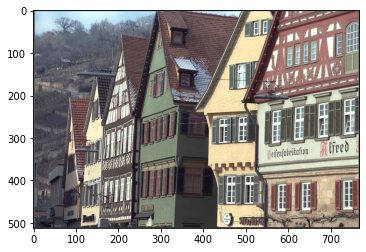

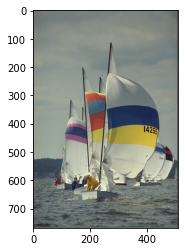

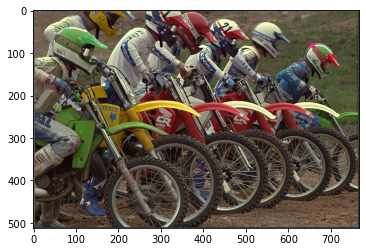

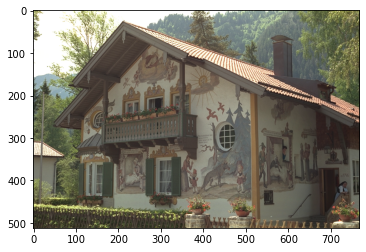

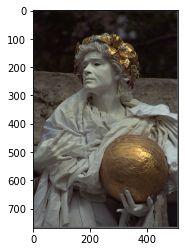

In [228]:
for i in range(5):
    randImagePath = os.path.join('Kodak/', np.random.choice((os.listdir("Kodak"))))
    img = Image.open(randImagePath)
    # img = cv2.imread(randImagePath)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    f = plt.figure()
    plt.imshow(img)


In [229]:
def load_image(path):
    """ Load image from path. Return a numpy array """
    image = Image.open(path)
    return np.asarray(image) #/ 255

def showImage(img):
    plt.figure()
    plt.imshow(img)
    plt.show()

def PlotGraphs(data, label_x):
  x=data[0]
  y=data[1]
  z=data[2]
  plt.scatter(x, y,c='red')
  plt.plot(x, y)
  plt.xlabel(label_x)
  plt.xticks(x) 
  plt.ylabel("CR")
  plt.show()

  plt.scatter(x, z,c='green')
  plt.plot(x, z)
  plt.xlabel(label_x)
  plt.xticks(x) 
  plt.ylabel("PSNR")
  plt.show()


In [230]:
def dct2(a):
    return fftpack.dct(fftpack.dct(a, axis=0, norm='ortho').T, axis=1, norm='ortho').T

def idct2(a):
    return fftpack.idct(fftpack.idct(a, axis=0 , norm='ortho').T, axis=1 , norm='ortho').T

def getLuminanceQuantizationMatrix(quality = 50):
    Q = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                  [12, 12, 14, 19, 26, 58, 60, 55],
                  [14, 13, 16, 24, 40, 57, 69, 56],
                  [14, 17, 22, 29, 51, 87, 80, 62],
                  [18, 22, 37, 56, 68, 109, 103, 77],
                  [24, 35, 55, 64, 81, 104, 113, 92],
                  [49, 64, 78, 87, 103, 121, 120, 101],
                  [72, 92, 95, 98, 112, 100, 103, 99]], dtype=int)
    if quality == 50:
        return Q
    if(quality <= 0):
        quality = 1
    if(quality > 100):
        quality = 100
    if(quality < 50):
        qualityScale = 5000 / quality
    else:
        qualityScale = 200 - quality * 2
    luminanceQuantTbl = np.array(np.floor((Q * qualityScale + 50) / 100))
    luminanceQuantTbl[luminanceQuantTbl == 0] = 1
    luminanceQuantTbl[luminanceQuantTbl > 255] = 255
    luminanceQuantTbl = luminanceQuantTbl.reshape([8, 8]).astype(int)
    return luminanceQuantTbl
    
def getChrominanceQuantizationMatrix(quality = 50):
    Q = np.array([[17, 18, 24, 47, 99, 99, 99, 99],
                  [18, 21, 26, 66, 99, 99, 99, 99],
                  [24, 26, 56, 99, 99, 99, 99, 99],
                  [47, 66, 99, 99, 99, 99, 99, 99],
                  [99, 99, 99, 99, 99, 99, 99, 99],
                  [99, 99, 99, 99, 99, 99, 99, 99],
                  [99, 99, 99, 99, 99, 99, 99, 99],
                  [99, 99, 99, 99, 99, 99, 99, 99]], dtype=int)
    
    if quality == 50:
        return Q
    if(quality <= 0):
        quality = 1
    if(quality > 100):
        quality = 100
    if(quality < 50):
        qualityScale = 5000 / quality
    else:
        qualityScale = 200 - quality * 2
    chrominanceQuantTbl = np.array(np.floor((Q * qualityScale + 50) / 100))
    chrominanceQuantTbl[chrominanceQuantTbl == 0] = 1
    chrominanceQuantTbl[chrominanceQuantTbl > 255] = 255
    chrominanceQuantTbl = chrominanceQuantTbl.reshape([8, 8]).astype(int)
    return chrominanceQuantTbl

def DCT_compression(im, threshold, Lquality, Cquality):    

    imsize = im.shape
    Height = imsize[0]
    Width = imsize[1]
    # dct = np.zeros(imsize)
    srcImageMatrix = im
    addedImageMatrix = np.zeros(imsize, dtype=np.uint8)
    for y in range(Height):
        for x in range(Width):
            addedImageMatrix[y][x] = srcImageMatrix[y][x]
            
    yImage,uImage,vImage = Image.fromarray(addedImageMatrix).convert('YCbCr').split()
    yImageMatrix = np.asarray(yImage)
    uImageMatrix = np.asarray(uImage)
    vImageMatrix = np.asarray(vImage)

    LQ = getLuminanceQuantizationMatrix(Lquality)
    CQ = getChrominanceQuantizationMatrix(Cquality)
    
    # Do 8x8 DCT on image (in-place)
    # for i in r_[:imsize[0]:8]:
    #     for j in r_[:imsize[1]:8]:
    #         dct[i:(i+8),j:(j+8)] = dct2( im[i:(i+8),j:(j+8)])

    yDctMatrix = np.zeros((Height, Width), dtype=np.uint8)
    uDctMatrix = np.zeros((Height, Width), dtype=np.uint8)
    vDctMatrix = np.zeros((Height, Width), dtype=np.uint8)

    yQuantMatrix = np.zeros((Height, Width), dtype=np.uint8)
    uQuantMatrix = np.zeros((Height, Width), dtype=np.uint8)
    vQuantMatrix = np.zeros((Height, Width), dtype=np.uint8)

    yReversedQuantMatrix = np.zeros((Height, Width), dtype=np.uint8)
    uReversedQuantMatrix = np.zeros((Height, Width), dtype=np.uint8)
    vReversedQuantMatrix = np.zeros((Height, Width), dtype=np.uint8)

    yIdctMatrix = np.zeros((Height, Width), dtype=np.uint8)
    uIdctMatrix = np.zeros((Height, Width), dtype=np.uint8)
    vIdctMatrix = np.zeros((Height, Width), dtype=np.uint8)

    Y_dct_thresh = np.zeros((Height, Width), dtype=np.uint8)
    U_dct_thresh = np.zeros((Height, Width), dtype=np.uint8)
    V_dct_thresh = np.zeros((Height, Width), dtype=np.uint8)

    
    for y in range(0, Height, 8):
        for x in range(0, Width, 8):
            # print('block (y,x): ',y, x, ' -> ', y + 8, x + 8)
            yDctMatrix[y:y + 8, x:x + 8] = dct2(yImageMatrix[y:y + 8, x:x + 8])
            uDctMatrix[y:y + 8, x:x + 8] = dct2(uImageMatrix[y:y + 8, x:x + 8])
            vDctMatrix[y:y + 8, x:x + 8] = dct2(vImageMatrix[y:y + 8, x:x + 8])

            yQuantMatrix[y:y + 8, x:x + 8] = np.rint(yDctMatrix[y:y + 8, x:x + 8] // LQ)
            uQuantMatrix[y:y + 8, x:x + 8] = np.rint(uDctMatrix[y:y + 8, x:x + 8] // CQ)
            vQuantMatrix[y:y + 8, x:x + 8] = np.rint(vDctMatrix[y:y + 8, x:x + 8] // CQ)

    #  Threshold
    Y_dct_thresh = yQuantMatrix * (abs(yQuantMatrix) > (threshold*np.max(yQuantMatrix)))
    percent_nonzeros = np.sum( Y_dct_thresh != 0.0 ) / (imsize[0]*imsize[1]*1.0)
    print ("Keeping only "+str(percent_nonzeros*100.0)+" of the DCT coefficients of Y Matrix")

    U_dct_thresh = uQuantMatrix * (abs(uQuantMatrix) > (threshold*np.max(uQuantMatrix)))
    percent_nonzeros = np.sum( U_dct_thresh != 0.0 ) / (imsize[0]*imsize[1]*1.0)
    print ("Keeping only "+str(percent_nonzeros*100.0)+" of the DCT coefficients of U Matrix")

    V_dct_thresh = vQuantMatrix * (abs(vQuantMatrix) > (threshold*np.max(vQuantMatrix)))
    percent_nonzeros = np.sum( V_dct_thresh != 0.0 ) / (imsize[0]*imsize[1]*1.0)
    print ("Keeping only "+str(percent_nonzeros*100.0)+" of the DCT coefficients of V Matrix")

    # im_dct = np.zeros(imsize)#regained image

    # for i in r_[:imsize[0]:8]:
    #     for j in r_[:imsize[1]:8]:
    #         im_dct[i:(i+8),j:(j+8)] = idct2(dct_thresh[i:(i+8),j:(j+8)]) 

    # im_dct = im_dct.astype(np.uint8)
    # return im_dct

    for y in range(0, Height, 8):
        for x in range(0, Width, 8):
            yReversedQuantMatrix[y:y + 8, x:x + 8] = np.rint(Y_dct_thresh[y:y + 8, x:x + 8]*LQ)
            uReversedQuantMatrix[y:y + 8, x:x + 8] = np.rint(U_dct_thresh[y:y + 8, x:x + 8]*CQ)
            vReversedQuantMatrix[y:y + 8, x:x + 8] = np.rint(V_dct_thresh[y:y + 8, x:x + 8]*CQ)

            yIdctMatrix[y:y + 8, x:x + 8] = idct2(yReversedQuantMatrix[y:y + 8, x:x + 8])
            uIdctMatrix[y:y + 8, x:x + 8] = idct2(uReversedQuantMatrix[y:y + 8, x:x + 8])
            vIdctMatrix[y:y + 8, x:x + 8] = idct2(vReversedQuantMatrix[y:y + 8, x:x + 8])



    Y = Image.fromarray(yIdctMatrix)
    U = Image.fromarray(uIdctMatrix)
    V = Image.fromarray(vIdctMatrix)
    merged_YUV = Image.merge('YCbCr', (Y, U, V)) 
    rgb_img = merged_YUV.convert('RGB') 
    
    return rgb_img

    


In [231]:
def psnr(original, compressed):
    mse = np.mean( (original - compressed) ** 2 )
    if mse == 0:
        return 100 
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

def ssim(original, compressed):
    meanSSIM = structural_similarity(original, compressed, multichannel=True)
    return meanSSIM 
    

def cr(original_img, compressed_img):
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    compressed_img = cv2.cvtColor(compressed_img, cv2.COLOR_BGR2RGB)

    compressed_img=cv2.imwrite("altered.png", compressed_img)
    print("Compressed File Size: "+str(os.path.getsize("altered.png")))
    original_img=cv2.imwrite("original.png", original_img)
    print("Original File Size: "+str(os.path.getsize("original.png")))

    return ( os.path.getsize("original.png")/os.path.getsize("altered.png") )
    
def metrics( original_img, compressed_img ):
    print("Achieved Peak Signal to Noise Ratio: " + str( psnr( original_img, compressed_img ) ))
    print("Achieved SSIM : " + str( ssim( original_img, compressed_img ) ))
    print("Achieved Compression Ratio: " + str( cr( original_img, compressed_img ) ))  
    return cr( original_img, compressed_img ), psnr( original_img, compressed_img )

Keeping only 34.52351888020833 of the DCT coefficients of Y Matrix
Keeping only 20.21153767903646 of the DCT coefficients of U Matrix
Keeping only 21.07721964518229 of the DCT coefficients of V Matrix
(512, 768, 3)
1179648
(512, 768, 3)
1179648
Achieved Peak Signal to Noise Ratio: 27.97343749556923
Achieved SSIM : 0.07950549477775262
Compressed File Size: 764154
Original File Size: 915652
Achieved Compression Ratio: 1.1982558489519128
Compressed File Size: 764154
Original File Size: 915652


(1.1982558489519128, 27.97343749556923)

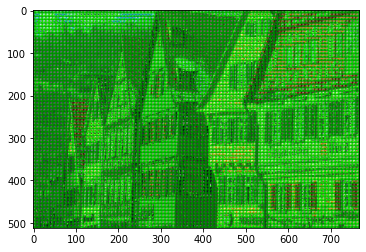

In [250]:
image = load_image("Kodak/kodim08.png")
# X_final= np.asarray(DCT_compression( image, 0.01,), dtype=None, order=None)
X_final = np.asarray(DCT_compression(image, 0.1, 50, 50))
print(image.shape)
print(image.size)
print(X_final.shape)
print(X_final.size)
plt.imshow(X_final)
metrics( image, X_final )


Testing for threshold = 0.0
Keeping only 67.67985026041666 of the DCT coefficients of Y Matrix
Keeping only 67.79657999674478 of the DCT coefficients of U Matrix
Keeping only 71.90068562825522 of the DCT coefficients of V Matrix
Metrics otained: 
Achieved Peak Signal to Noise Ratio: 28.008606437239607
Achieved SSIM : 0.20297753567522867
Compressed File Size: 979462
Original File Size: 915652
Achieved Compression Ratio: 0.9348519901741976
Compressed File Size: 979462
Original File Size: 915652
Achieved Peak Signal to Noise Ratio: 28.008606437239607
Achieved SSIM : 0.20297753567522867
Compressed File Size: 979462
Original File Size: 915652
Achieved Compression Ratio: 0.9348519901741976
Compressed File Size: 979462
Original File Size: 915652
Testing for threshold = 0.1
Keeping only 34.52351888020833 of the DCT coefficients of Y Matrix
Keeping only 20.21153767903646 of the DCT coefficients of U Matrix
Keeping only 21.07721964518229 of the DCT coefficients of V Matrix
Metrics otained: 
Achi

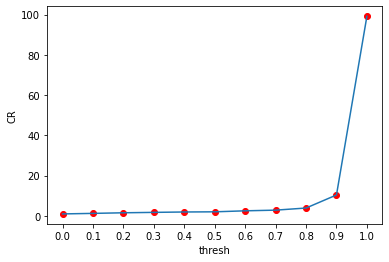

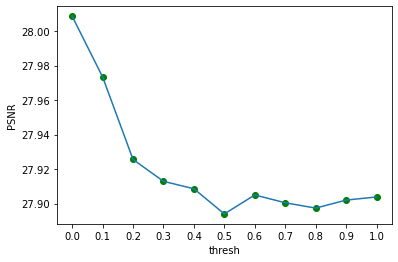

In [249]:
image = load_image("Kodak/kodim08.png")
thresh = 0.00
i=0
eval_data = np.zeros((11, 3), dtype=float)#col1=K, col2=cr, col3=psnr
while thresh<=1:
  eval_data[i][0] = thresh
  print("Testing for threshold = "+str(thresh))
  X_compressed = np.asarray( DCT_compression( image, thresh, 50, 50 ), dtype=None, order=None )#DCT Transform 
  print("Metrics otained: ")
  metrics( image, X_compressed )
  eval_data[i][1], eval_data[i][2] = metrics( image, X_compressed )
  thresh+=0.1
  i+=1
print("Data obtained after evaluation: ")
print(eval_data)
PlotGraphs(np.ndarray.transpose(eval_data), 'thresh')